Importing the Libraries required

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM

Defining the function for pre processing the data

In [2]:
def new_dataset(dataset, step_size):
    data_X, data_Y = [], []
    for i in range(len(dataset)-step_size-1):
        a = dataset[i:(i+step_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + step_size, 0])
    return np.array(data_X), np.array(data_Y)

In [3]:
np.random.seed(7)

Loading the data set

In [4]:
dataset = pd.read_csv('Apple_Share_Price.csv', usecols=[1,2,3,4])
dataset = dataset.reindex(index = dataset.index[::-1])

Creating the index for flexibility

In [5]:
obs = np.arange(1, len(dataset) + 1, 1)

Taking Different Indicators for Prediction

In [6]:
OHLC_avg = dataset.mean(axis = 1)
HLC_avg = dataset[['High', 'Low', 'Close']].mean(axis = 1)
close_val = dataset[['Close']]

Plotting all the Indicators in One Plot

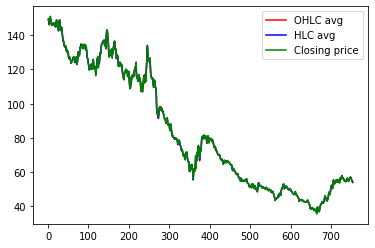

In [7]:
plt.plot(obs, OHLC_avg, 'r', label = 'OHLC avg')
plt.plot(obs, HLC_avg, 'b', label = 'HLC avg')
plt.plot(obs, close_val, 'g', label = 'Closing price')
plt.legend(loc = 'upper right')
plt.show()

Preparing the time series data

In [8]:
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1)) # 1664
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)

In [9]:
from sklearn import preprocessing

Splitting the data set into training and testing data

In [10]:
train_OHLC = int(len(OHLC_avg) * 0.75)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

In [11]:
trainX, trainY = new_dataset(train_OHLC, 1)
testX, testY = new_dataset(test_OHLC, 1)

In [12]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
step_size = 1

Defining the LSTM Model

In [13]:
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(16,activation = 'relu'))
model.add(Dense(1))
model.add(Activation('linear'))

Compiling and training the model

In [14]:
model.compile(loss='mean_squared_error', optimizer='adam') 
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
563/563 - 7s - loss: 0.0514
Epoch 2/20
563/563 - 5s - loss: 0.0012
Epoch 3/20
563/563 - 4s - loss: 9.8415e-04
Epoch 4/20
563/563 - 5s - loss: 8.8717e-04
Epoch 5/20
563/563 - 4s - loss: 7.2125e-04
Epoch 6/20
563/563 - 5s - loss: 6.0173e-04
Epoch 7/20
563/563 - 5s - loss: 5.3528e-04
Epoch 8/20
563/563 - 4s - loss: 4.3523e-04
Epoch 9/20
563/563 - 4s - loss: 3.8790e-04
Epoch 10/20
563/563 - 4s - loss: 3.7163e-04
Epoch 11/20
563/563 - 4s - loss: 3.2177e-04
Epoch 12/20
563/563 - 4s - loss: 3.0693e-04
Epoch 13/20
563/563 - 4s - loss: 3.4853e-04
Epoch 14/20
563/563 - 5s - loss: 3.4677e-04
Epoch 15/20
563/563 - 4s - loss: 3.5869e-04
Epoch 16/20
563/563 - 4s - loss: 3.3532e-04
Epoch 17/20
563/563 - 4s - loss: 3.2012e-04
Epoch 18/20
563/563 - 4s - loss: 3.3917e-04
Epoch 19/20
563/563 - 4s - loss: 3.3036e-04
Epoch 20/20
563/563 - 4s - loss: 3.3841e-04


Predicting the vules using the defined model

In [15]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

De-Normalizing the data for plotting the values

In [16]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

RMSE Value for the training Data

In [17]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))

Train RMSE: 1.73


RMSE Value for the Testing Data

In [18]:

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

Test RMSE: 1.20


Creating the similar dataset for plotting the training predictions

In [19]:
trainPredictPlot = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict

Creating the similar dataset for plotting the testing predictions

In [20]:
testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict

De-Normalizing the main data set

In [21]:
OHLC_avg = scaler.inverse_transform(OHLC_avg)

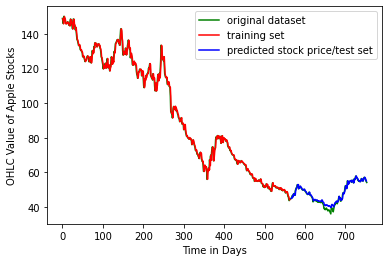

In [22]:
plt.plot(OHLC_avg, 'g', label = 'original dataset')
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of Apple Stocks')
plt.show()

Prediction of Future Values

In [23]:
last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
print ("Last Day Value:", np.asscalar(last_val))
print ("Next Day Value:", np.asscalar(last_val*next_val))

Last Day Value: 54.917999267578125
Next Day Value: 54.82136535644531


C:\Users\raja\AppData\Local\Temp/ipykernel_1632/1867709383.py:4: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  print ("Last Day Value:", np.asscalar(last_val))
C:\Users\raja\AppData\Local\Temp/ipykernel_1632/1867709383.py:5: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  print ("Next Day Value:", np.asscalar(last_val*next_val))
